In [1]:
pip install dash dash-bootstrap-components pandas plotly


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install pyngrok


In [3]:
from pyngrok import ngrok
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\harib\AppData\Local\Temp\ipykernel_10060\153387550.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\harib\AppData\Local\Temp\ipykernel_10060\153387550.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [4]:

# Load the dataset
df = pd.read_csv('charitydata.csv')

In [5]:
columns = ['damt', 'hinc', 'Validation', 'genf', 'tgif', 'kids', 'donr','home']


In [6]:
df[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6002 entries, 0 to 6001
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   damt        6002 non-null   int64 
 1   hinc        6002 non-null   int64 
 2   Validation  6002 non-null   object
 3   genf        6002 non-null   int64 
 4   tgif        6002 non-null   int64 
 5   kids        6002 non-null   int64 
 6   donr        6002 non-null   int64 
 7   home        6002 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 375.3+ KB


In [7]:
df.columns

Index(['ID', 'reg1', 'reg2', 'reg3', 'reg4', 'home', 'kids', 'hinc', 'genf',
       'wrat', 'avhv', 'incm', 'inca', 'plow', 'npro', 'tgif', 'lgif', 'rgif',
       'tdon', 'tlag', 'agif', 'donr', 'damt', 'Validation'],
      dtype='object')

In [8]:
# Function to remove outliers from the 'damt' column using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the 'damt' column
df = remove_outliers(df, 'damt')
df = remove_outliers(df, 'agif')

<Figure size 1000x600 with 0 Axes>

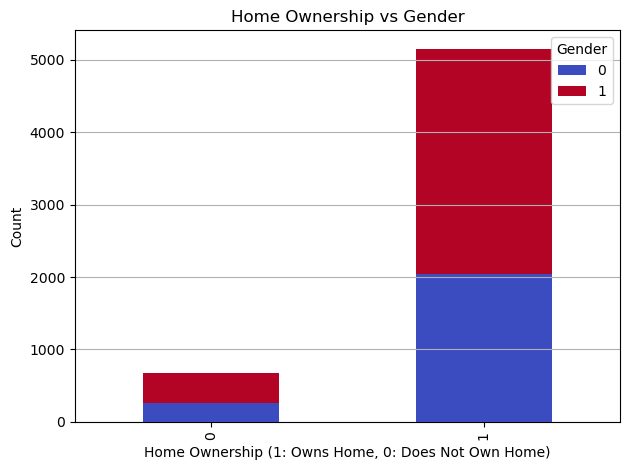

In [9]:

# Grouping data for the stacked bar plot based on 'home' and 'genf'
grouped_data = df.groupby(['home', 'genf']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True, colormap='coolwarm')

# Adding titles and labels
plt.title('Home Ownership vs Gender')
plt.xlabel('Home Ownership (1: Owns Home, 0: Does Not Own Home)')
plt.ylabel('Count')
plt.legend(title='Gender', loc='upper right')
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()



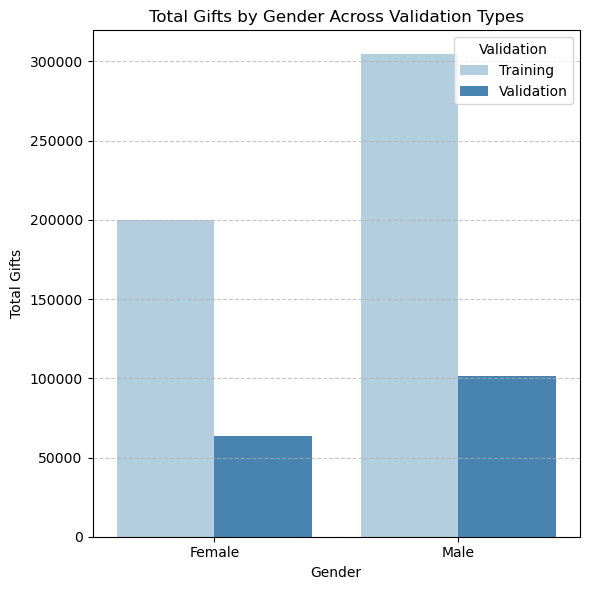

In [10]:

# Aggregate the data by gender and validation
agg_df = df.groupby(['genf', 'Validation'])['tgif'].sum().reset_index()

plt.figure(figsize=(6, 6))

    # Create a bar plot
sns.barplot(x='genf', y='tgif', hue='Validation', data=agg_df, palette='Blues')

    # Customize the plot
plt.title('Total Gifts by Gender Across Validation Types')
plt.xlabel('Gender')
plt.ylabel('Total Gifts')
plt.xticks([0, 1], labels=['Female', 'Male'])
plt.legend(title='Validation', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



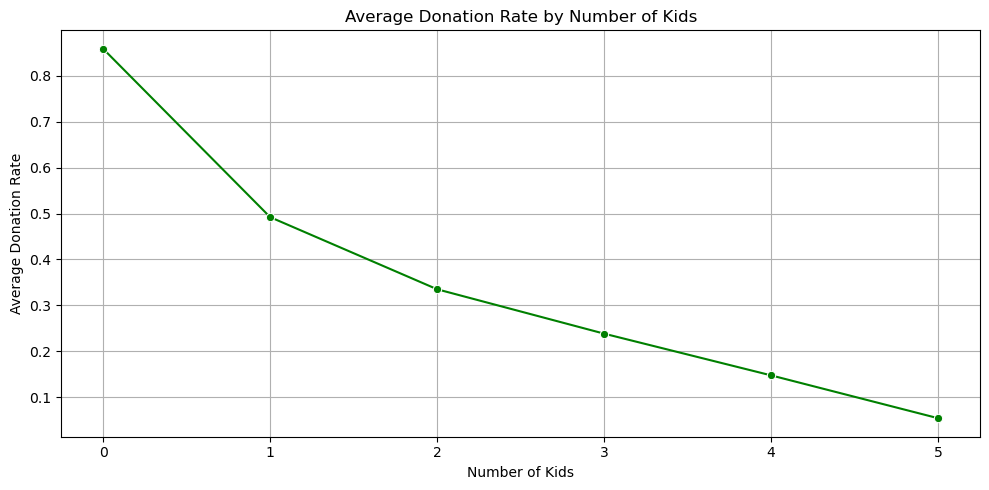

In [11]:

    # Calculate the average donation rate by the number of kids
avg_donation_rate = df.groupby('kids')['donr'].mean().reset_index()

    # Generate the line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='kids', y='donr', data=avg_donation_rate, marker='o', color='green')

    # Customize the plot
plt.title('Average Donation Rate by Number of Kids')
plt.xlabel('Number of Kids')
plt.ylabel('Average Donation Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:

# Initialize the Dash app
app = dash.Dash(__name__)

# Function to generate figures with enhanced color palettes
def generate_figures(filtered_data):
    # Chart 1: Stacked Bar Plot - Home Ownership vs Gender
    grouped_data = filtered_data.groupby(['home', 'genf']).size().unstack(fill_value=0).reset_index()
    
    # Melt the DataFrame to convert it to a long format suitable for Plotly Express
    melted_data = grouped_data.melt(id_vars='home', value_vars=grouped_data.columns[1:], 
                                    var_name='Gender', value_name='Count')
    
    # Map home ownership values to more descriptive labels
    home_labels = {0: "Does Not Own Home", 1: "Owns Home"}
    melted_data['home'] = melted_data['home'].map(home_labels)
    
    # Generate the first chart: Home Ownership vs Gender
    fig1 = px.bar(
        melted_data,
        x='home',
        y='Count',
        color='Gender',
        title='Home Ownership vs Gender',
        labels={'home': 'Home Ownership', 'Count': 'Count'},
        barmode='stack',
        color_discrete_sequence=px.colors.sequential.Plasma
    )
    fig1.update_layout(
        plot_bgcolor='#f9f9f9',
        paper_bgcolor='#f9f9f9',
        font_color='#333',
        xaxis_title='Home Ownership',
        yaxis_title='Count'
    )

    # Chart 2: Total Gifts by Gender
    fig2 = px.bar(
        filtered_data,
        x='genf',
        y='tgif',
        color='Validation',
        barmode='group',
        title='Total Gifts by Gender Across Validation Types',
        labels={'genf': 'Gender', 'tgif': 'Total Gifts'},
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    fig2.update_layout(
        plot_bgcolor='#f9f9f9',
        paper_bgcolor='#f9f9f9',
        font_color='#333',
        xaxis_title='Gender',
        yaxis_title='Total Gifts'
    )

    # Chart 3: Average Donation Rate by Number of Kids
    donation_rate = filtered_data.groupby('kids')['donr'].mean().reset_index()
    fig3 = px.line(
        donation_rate,
        x='kids',
        y='donr',
        title='Average Donation Rate by Number of Kids',
        labels={'kids': 'Number of Kids', 'donr': 'Average Donation Rate'},
        markers=True,
        line_shape='linear'
    )
    fig3.update_traces(line_color='mediumseagreen', marker=dict(size=8))
    fig3.update_layout(
        plot_bgcolor='#f9f9f9',
        paper_bgcolor='#f9f9f9',
        font_color='#333',
        xaxis_title='Number of Kids',
        yaxis_title='Average Donation Rate'
    )

    return fig1, fig2, fig3

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("Charitable Donations Analysis Dashboard", style={'text-align': 'center', 'color': '#333'}),

    # Dropdown filter for selecting "Training" or "Validation"
    html.Label("Select Validation Type:", style={'color': '#333'}),
    dcc.Dropdown(
        id='validation-filter',
        options=[{'label': val, 'value': val} for val in df['Validation'].unique()],
        value='Training',
        clearable=False,
        style={'color': '#333', 'background-color': '#e7e7e7'}
    ),

    # Row 1: Two charts side by side
    html.Div([
        dcc.Graph(id='chart1', style={'width': '48%', 'display': 'inline-block'}),
        dcc.Graph(id='chart2', style={'width': '48%', 'display': 'inline-block'})
    ], style={'display': 'flex', 'justify-content': 'space-between', 'margin-top': '20px'}),

    # Row 2: Single chart
    html.Div([
        dcc.Graph(id='chart3', style={'width': '100%', 'margin-top': '20px'})
    ])
])

# Define callback to update charts based on filter
@app.callback(
    [Output('chart1', 'figure'),
     Output('chart2', 'figure'),
     Output('chart3', 'figure')],
    [Input('validation-filter', 'value')]
)
def update_charts(selected_validation):
    # Filter the data based on the selected validation type
    filtered_data = df[df['Validation'] == selected_validation]
    return generate_figures(filtered_data)

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)


In [13]:
# Paste your authtoken here
ngrok.set_auth_token("2owtpbmsxPjdQoglSHsL2drXNek_4Nh6Ny8NiZxzsvWBWCtwp")


In [14]:
public_url = ngrok.connect(8050)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://c707-2600-6c56-7cf0-2280-d0d5-d9c0-6bbf-17ba.ngrok-free.app" -> "http://localhost:8050"


t=2024-11-16T23:06:50-0600 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=a44b3ce61c8c clientid=21458ed4bd0de677b6d9b356a9781dd0
t=2024-11-16T23:06:50-0600 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=a22b013d02c4 err="session closed"
t=2024-11-16T23:10:25-0600 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=ccfb91b10401 clientid=21458ed4bd0de677b6d9b356a9781dd0
t=2024-11-16T23:10:25-0600 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=a22b013d02c4 err="session closed"
t=2024-11-16T23:10:25-0600 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: no such host"
t=2024-11-16T23:10:26-0600 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="failed to dial ngrok server with addre